<a href="https://colab.research.google.com/github/Shi-raishi/Research/blob/main/pattern1_food_6pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ①foodシートの食品変数MILK1～SAKE6までの摂取量<br>
## 分析前にnutrシートにある変数EER, EN から求まるエネルギー補正係数(EER/EN) をかける<br>

### BMIメモ<br>
18.5未満	痩せ 鉄欠乏などの栄養不良による貧血のリスク<br>
18.5～25	普通 22のときが標準体重で、最も病気になりにくい<br>
25～30	肥満レベル1 25を超えると、脂質異常症や糖尿病、高血圧などの生活習慣病のリスクが2倍以上<br>
30～35	肥満レベル2 30を超えると高度な肥満として、より積極的な減量治療が必要<br>
35～40	肥満レベル3<br>
40～	肥満レベル4<br>

＊IDの重複削除とデータの結合、ECF,BMIの作成と欠損処理、異常値確認、LiNGAM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Google Colabにlingamのライブラリをインストールする
!pip install lingam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 30.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import print_causal_directions, print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.2', '1.5.3', '0.20.1', '1.8.2']


In [2]:
%cd /content/drive/MyDrive/'Colab Notebooks'
%ls CSV

/content/drive/MyDrive/Colab Notebooks
'BDHQ フォーマット LongDataSet (f_nutr1).csv'
'BDHQ フォーマット LongDataSet (nutr).csv'
'BDHQ フォーマット LongDataSet (signal).csv'
'BDHQ 児童生徒用フォーマット LongDataSet (food2).csv'
'BDHQ 成人用フォーマット LongDataSet (food).csv'
 Shift-JISに変換したもの/


##  関数を定義

In [3]:
# 前処理用（結合、重複削除、NA削除）
def preprocess(df1, df2):
  # df1, df2の重複を確認
  print(f"ID1に重複のある行数\tdf1:{df1['ID1'].duplicated(keep=False).sum()}\tdf2:{df2['ID1'].duplicated(keep=False).sum()}")

  # df2からID1の重複を除去
  df2_cleaned = df2.drop_duplicates(subset='ID1', keep=False)

  # 左結合
  merged_data = pd.merge(df1, df2_cleaned, on='ID1', how='left')

  # 結合後のデータフレームのID1の重複を削除
  merged_data = merged_data.drop_duplicates(subset='ID1',keep=False)# 重複の確認
  print(f"結合後のデータ数:{len(merged_data)}")

  ## エネルギー補正係数とBMIを作成
  # merged_dataのコピーを作成（SettingWithCopyWarningというエラーが出るため）
  merged_data_copy = merged_data.copy()

  # 新しい列を追加(ECF:Energy correction facto(エネルギー補正係数))
  merged_data_copy['BMI'] = merged_data_copy['BW'] / ((merged_data_copy['BH'] / 100) ** 2)
  merged_data_copy['ECF'] = merged_data_copy['EER'] / merged_data_copy['EN']

  # 変数を選択
  selected_columns = merged_data_copy.loc[:, 'MILK1':'SAKE6'].copy()
  selected_columns['BMI'] = merged_data_copy['BMI']
  selected_columns['ECF'] = merged_data_copy['ECF']
  selected_columns['AGE'] = merged_data_copy['AGE']
  selected_columns['SEX'] = merged_data_copy['SEX']

  # NA処理
  print(f"NAを含むデータ数:{selected_columns[selected_columns.isna().any(axis=1)].shape[0]}")
  selected_columns_cleaned = selected_columns.dropna()
  selected_columns_cleaned.describe()
  display(selected_columns_cleaned.describe())

  print(f"処理後のデータ数:{len(selected_columns_cleaned)}")

  return selected_columns_cleaned

In [4]:
# 変数同士の相関を確認
def corrMatrix(df):
  # 相関行列の作成
  corr_matrix = df.corr()

  # 高い相関を持つ変数ペアの抽出
  threshold = 0.5  # 閾値を設定
  high_corr_var = [(column, index, corr_matrix[column][index]) for column in corr_matrix.columns for index in corr_matrix.columns if (corr_matrix[column][index] > threshold) & (column != index)]
  for var_pair in high_corr_var:
      print(var_pair)

In [5]:
# 特定の変数と他の変数との相関を確認
def targetCorrMatrix(df):
  df = 'VEG3'
  correlations = df.corrwith(df[df])
  correlations.sort_values(ascending=False)

In [6]:
# ヒートマップで相関関係の可視化
def heatMap(df):
  plt.figure(figsize=(15, 15))
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
  plt.show()

In [7]:
# 個々の変数の分布を確認
def distribution(df):
  for column in df.columns:
      plt.figure()
      sns.histplot(df[column], kde=True)
      plt.title(column)
      plt.show()

In [8]:
# 変数の0データを確認
def countZeroData(df):
  # 各変数における0の数をカウントし、少ない順にソート
  zero_counts_sorted = (df == 0).sum().sort_values()
  # 各変数における0データ数の表示
  print(zero_counts_sorted)

In [9]:
# 0データの数をグラフで確認
def countAvairableVariable(df):
  # 0が含まれる数をカウント
  zero_counts = (df == 0).sum().sort_values()

  # グラフのサイズを設定
  plt.figure(figsize=(12, 9))

  # 棒グラフの作成
  sns.barplot(x=len(df)-zero_counts.values, y=zero_counts.index)

  # グラフのタイトルとラベルを設定
  plt.title('Number of non-zero data in each variable')
  plt.xlabel('number of non-zero data')
  plt.ylabel('variable name')

  # グラフの表示
  plt.show()

In [10]:
def boxplot(df):
  # dfのすべての列に対して箱ひげ図を描画
  plt.figure(figsize=(10, 6))
  sns.boxplot(data=df)
  plt.title("Boxplot of df")
  plt.show()

In [11]:
# 与えられたデータフレームの変数を見る
def checksVariables(df):
  # non-zeroのデータ数をグラフで確認
  countAvairableVariable(df)
  # 相関行列を確認
  corrMatrix(df)
  # ヒートマップ確認
  heatMap(df)
  # # 各変数の分布を確認
  # distribution(df)
  # 箱ひげ図を描画
  # boxplot(df)

In [12]:


# 解析に使用するデータフレームを返す
def select_variables(df,columns):
    # 解析に使用する変数のデータフレームを作成
    df = df[columns]

    # 基本統計量の確認
    # print(f"データ数:{len(df)}")
    # display(df.describe())

    # # 各列について、上:0.05%,下:0.05%のデータを外れ値として除去
    # for column in df.columns:
    #     lower_limit = df[column].quantile(0.005)
    #     upper_limit = df[column].quantile(0.995)
    #     df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    # # 修正されたデータフレームを確認
    # print(f"上:0.05%,下:0.05%を除去後のデータ数:{len(df)}")
    # display(df.describe())

    return df

In [13]:
# 3σ法による外れ値の除去(正規分布)
def remove_outliers_3sigma(df, columns_to_process=None):
    if columns_to_process is None:
        columns_to_process = df.columns
    for column in columns_to_process:
        mean = df[column].mean()
        std = df[column].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        # print(f"{column}:{len(df)}")
    return df

# IQRによる外れ値の除去
def remove_outliers_iqr(df, columns_to_process=None):
    if columns_to_process is None:
        columns_to_process = df.columns
    for column in columns_to_process:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        # print(f"{column}:{len(df)}")
    return df

# # 使い方
# columns_to_process = ['A', 'B']
# df_cleaned_3sigma = remove_outliers_3sigma(df, columns_to_process)
# df_cleaned_iqr = remove_outliers_iqr(df, columns_to_process)

## データ準備

In [14]:
# CSVの読み込み
data_nutr = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (nutr).csv')
data_food = pd.read_csv('./CSV/BDHQ 成人用フォーマット LongDataSet (food).csv')

In [15]:
print(len(data_food),len(data_nutr))

2797 3329


In [16]:
# 前処理（結合、重複削除、NA削除）
preprocessed_df = preprocess(data_food,data_nutr)

ID1に重複のある行数	df1:59	df2:116
結合後のデータ数:2738
NAを含むデータ数:28


,MILK1,MILK2,MEAT1,MEAT2,MEAT3,MEAT4,FISH1,FISH2,FISH3,FISH4,...,MISO,SAKE2,SAKE3,SAKE4,SAKE5,SAKE6,BMI,ECF,AGE,SEX
count,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,...,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000
mean,34.450642,79.694374,23.531268,34.294909,8.946164,0.892269,12.226458,10.132537,4.204260,22.482537,...,179.432363,15.660380,79.284835,16.106608,3.315123,4.317804,22.857073,1.282921,53.947232,1.609963
std,66.088541,85.327715,22.539538,26.499153,9.059440,3.185412,16.532668,17.556528,6.328175,24.219372,...,130.784427,54.275422,195.126181,44.270461,17.394380,22.675125,3.506897,0.492430,19.101461,0.487848
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.473917,0.259846,15.000000,1.000000
25%,0.000000,0.000000,7.968711,14.229841,2.309771,0.000000,5.520000,0.000000,0.000000,5.866667,...,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.406081,0.969508,41.000000,1.000000
50%,0.000000,53.571429,14.785714,30.803571,5.142857,0.000000,7.083299,4.781227,3.066667,13.198693,...,132.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.456083,1.187820,58.000000,2.000000
75%,39.567122,136.111524,33.883929,39.132063,11.785714,0.000000,14.457143,10.842857,5.914286,31.428571,...,249.455301,0.000000,61.039286,1.928571,0.000000,0.000000,24.820016,1.476786,69.000000,2.000000
max,415.758836,415.758836,239.061331,239.061331,83.151767,92.390852,254.998753,191.249064,82.800000,192.000000,...,990.891892,540.000000,1899.000000,270.000000,201.000000,330.000000,50.781250,5.894433,96.000000,2.000000


処理後のデータ数:2710


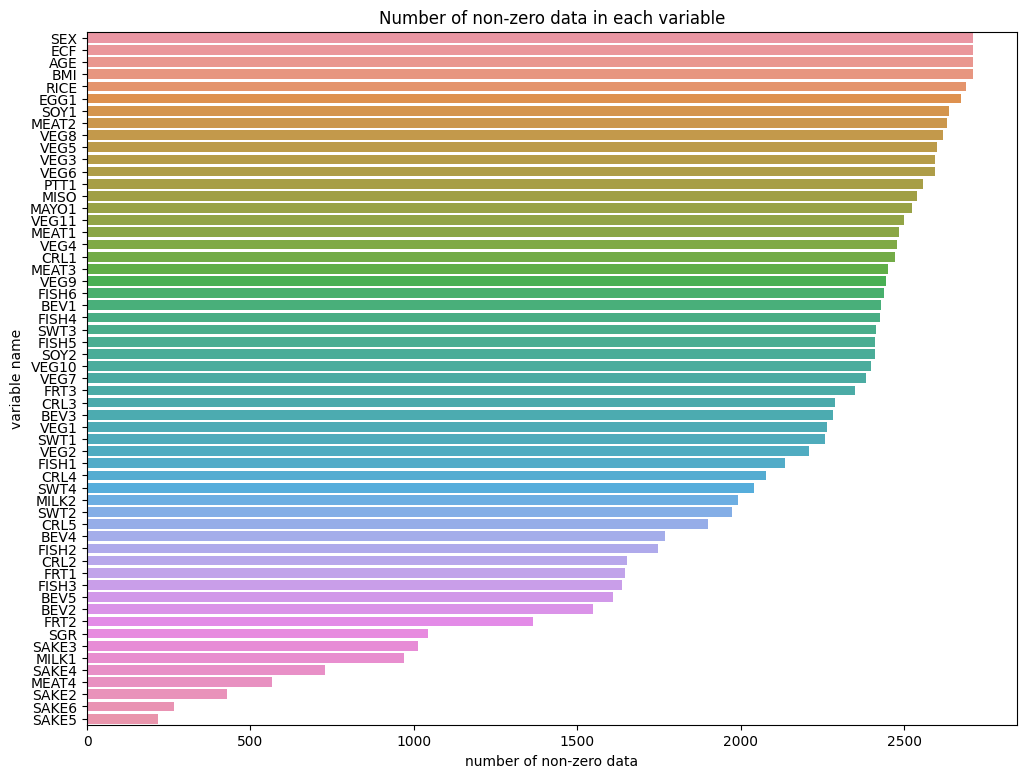

('VEG3', 'VEG5', 0.5111778005695479)
('VEG5', 'VEG3', 0.5111778005695479)
('VEG5', 'VEG6', 0.5423405377044409)
('VEG5', 'VEG7', 0.5130633464363883)
('VEG6', 'VEG5', 0.5423405377044409)
('VEG6', 'VEG8', 0.5394437595174767)
('VEG7', 'VEG5', 0.5130633464363883)
('VEG8', 'VEG6', 0.5394437595174767)
('RICE', 'MISO', 0.5631280489864002)
('MISO', 'RICE', 0.5631280489864002)


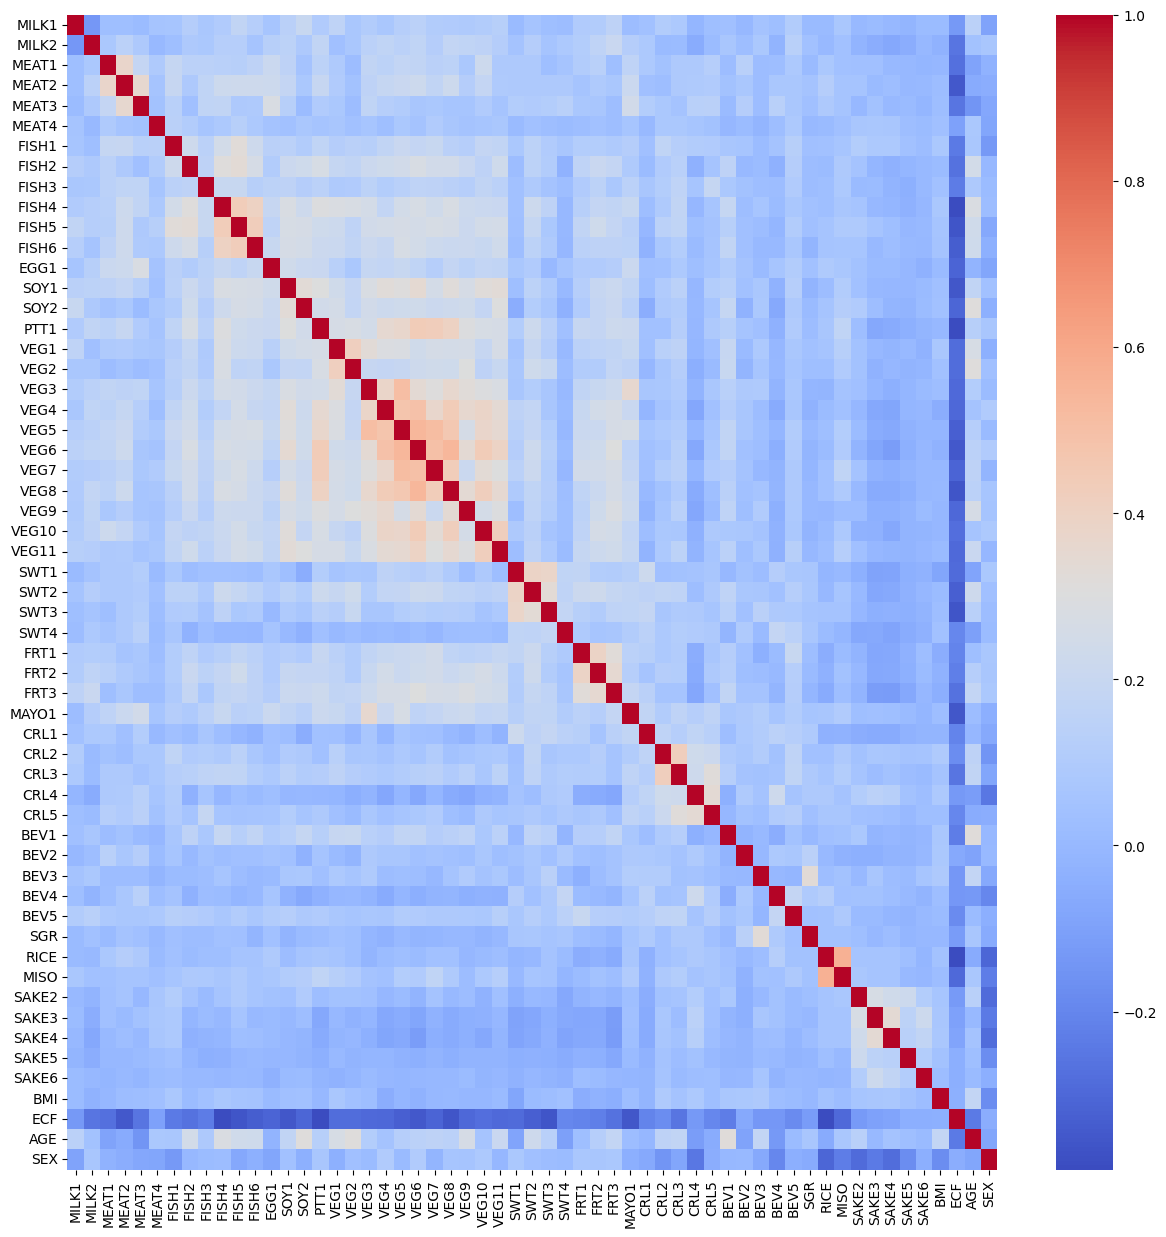

In [17]:
# 変数の相関を確認
checksVariables(preprocessed_df)

In [18]:
# 使用する変数を選択
columns_for_lingam = ['RICE','EGG1','SOY2','MEAT2','VEG4','PTT1','CRL1','FISH5','ECF','BMI','AGE','SEX']
variables_df = preprocessed_df[columns_for_lingam]
len(variables_df)

2710

In [19]:
def ecf_outliers_process(df):
  # ECF列を掛ける
  df = df.drop('ECF', axis=1).multiply(df['ECF'], axis=0)

  # (AGE,SEXを除く変数)
  columns_to_process = df.columns.to_list()
  columns_to_process.remove('AGE')

  # 箱ヒゲ
  # boxplot(df[columns_to_process])

  # # 各変数の変動係数
  # coeff_of_variation = df[columns_to_process].std() / df[columns_to_process].mean() * 100
  # print(coeff_of_variation)

  # # IQRによる外れ値の除去
  df_cleaned_iqr = remove_outliers_iqr(df,columns_to_process)

  # データフレームから少なくとも1つの変数に0データを含む行を除去
  # df = df[(df != 0).all(axis=1)]

  return df_cleaned_iqr[columns_to_process]

In [20]:
def ecf_outliers_process_drop_0data(df):
  # ECF列を掛ける
  df = df.drop('ECF', axis=1).multiply(df['ECF'], axis=0)

  # (AGE,SEXを除く変数)
  columns_to_process = df.columns.to_list()
  columns_to_process.remove('AGE')

  # 箱ヒゲ
  # boxplot(df[columns_to_process])

  # # 各変数の変動係数
  # coeff_of_variation = df[columns_to_process].std() / df[columns_to_process].mean() * 100
  # print(coeff_of_variation)

  # # IQRによる外れ値の除去
  df_cleaned_iqr = remove_outliers_iqr(df,columns_to_process)

  # データフレームから少なくとも1つの変数に0データを含む行を除去
  df_cleaned_iqr = df_cleaned_iqr[(df_cleaned_iqr != 0).all(axis=1)]

  return df_cleaned_iqr[columns_to_process]

In [21]:
# fnutr1_data_list <- 全体データ、全体データ(droped_0data)、男性群、男性群(droped_0data)、女性群、女性群(droped_0data)
food_data_list = []
food_data_list.append(ecf_outliers_process(variables_df.drop(['SEX'], axis=1)))
food_data_list.append(ecf_outliers_process_drop_0data(variables_df.drop(['SEX'], axis=1)))

food_data_list.append(ecf_outliers_process(variables_df[variables_df['SEX'] == 1].drop('SEX', axis=1)))
food_data_list.append(ecf_outliers_process_drop_0data(variables_df[variables_df['SEX'] == 1].drop('SEX', axis=1)))

food_data_list.append(ecf_outliers_process(variables_df[variables_df['SEX'] == 2].drop('SEX', axis=1)))
food_data_list.append(ecf_outliers_process_drop_0data(variables_df[variables_df['SEX'] == 2].drop('SEX', axis=1)))

In [22]:
for x in food_data_list:
  display(x.describe())
  print(len(x))

,RICE,EGG1,SOY2,MEAT2,VEG4,PTT1,CRL1,FISH5,BMI
count,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000
mean,352.121176,46.918528,23.469439,36.764792,38.408798,58.307647,31.618890,17.863935,26.891968
std,153.893042,27.230184,19.671525,19.743534,30.647322,40.151165,27.045175,13.264620,7.791584
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.572792
25%,241.796441,26.594767,7.071137,22.072394,13.121587,25.291649,9.920901,8.293610,21.253137
50%,338.418074,41.916214,19.157243,35.715815,32.602505,53.112212,24.439321,14.573185,25.944803
75%,451.053438,66.346081,36.672895,47.882736,57.028210,80.091808,47.658066,25.362604,31.802504
max,786.282916,132.214650,84.532431,93.229502,137.246588,171.260301,111.729016,57.714062,49.550435


2038


,RICE,EGG1,SOY2,MEAT2,VEG4,PTT1,CRL1,FISH5,BMI
count,1431.000000,1431.000000,1431.000000,1431.000000,1431.000000,1431.000000,1431.000000,1431.000000,1431.000000
mean,345.751061,46.536565,25.253228,37.410705,41.732914,62.370206,32.118735,19.816643,25.938525
std,145.237853,25.517430,18.349656,18.702679,29.598959,39.028386,24.977900,12.506683,7.406195
min,45.810448,2.849216,2.174038,4.133395,2.520397,6.133617,2.960627,4.097854,4.572792
25%,241.831708,26.996253,9.220925,25.142681,16.315393,28.924869,11.509010,9.738992,20.685997
50%,331.215202,42.802279,20.919986,35.571693,34.813071,56.685813,24.914868,15.753574,25.014491
75%,435.558632,64.398424,37.400992,47.021332,60.661049,83.644441,47.041289,27.915817,30.276492
max,783.799534,130.560966,84.532431,93.229502,137.246588,171.127902,111.584957,57.324388,49.084795


1431


,RICE,EGG1,SOY2,MEAT2,VEG4,PTT1,CRL1,FISH5,BMI
count,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000
mean,436.038563,49.729853,24.761058,39.306738,32.928573,52.447271,34.528408,20.807009,28.212800
std,179.960227,29.407954,20.838816,21.356205,28.034886,38.001186,30.968446,15.002409,8.095819
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.442325
25%,308.303650,27.534802,7.934555,22.592652,10.119720,22.688751,9.314619,9.742332,22.861658
50%,427.485716,43.266664,20.746264,38.309453,25.507092,44.961927,26.409109,17.012594,27.450384
75%,556.201318,71.720796,37.954666,50.536112,47.528066,73.873421,51.521954,28.989233,33.561416
max,943.090180,141.563883,87.677444,100.315376,113.498375,158.400688,122.493398,65.621384,50.773823


795


,RICE,EGG1,SOY2,MEAT2,VEG4,PTT1,CRL1,FISH5,BMI
count,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000
mean,422.716592,49.406576,27.106029,39.700120,37.612669,58.190095,36.482564,22.848288,27.381860
std,171.406976,26.839139,19.211980,20.783017,26.959223,36.097979,28.862017,13.839463,8.047365
min,55.861558,2.849216,2.191527,4.654817,2.804385,6.198975,3.466221,5.590824,8.442325
25%,303.657787,28.599723,10.572710,24.681702,14.863414,28.171849,11.824275,11.615213,22.087140
50%,413.880618,43.896288,22.495138,37.904883,33.680406,55.942335,29.188002,18.465547,26.692199
75%,536.733656,70.430002,40.126440,49.058035,52.064720,77.913248,52.314833,31.376090,32.405537
max,943.090180,141.563883,86.931841,100.315376,113.498375,157.713018,119.496525,62.280842,50.773823


522


,RICE,EGG1,SOY2,MEAT2,VEG4,PTT1,CRL1,FISH5,BMI
count,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000
mean,309.406263,45.262080,23.045365,35.203158,41.163863,61.381334,29.545229,16.288471,25.936481
std,127.839082,25.547872,18.981716,18.729111,31.535775,41.494689,24.335050,12.191876,7.311996
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.402398
25%,220.544543,26.189478,6.871741,21.847326,14.710483,26.597266,9.896174,7.645472,20.757798
50%,304.725229,41.349065,18.717105,33.977083,34.050059,54.347896,23.033002,13.055454,24.904942
75%,391.977394,63.087208,35.934780,45.333347,62.042036,84.768710,44.311133,23.434831,30.208817
max,667.278528,121.863414,82.563676,87.638973,146.140599,188.922969,102.974470,54.390121,46.953956


1252


,RICE,EGG1,SOY2,MEAT2,VEG4,PTT1,CRL1,FISH5,BMI
count,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000
mean,307.943933,44.340764,24.180222,36.175627,43.333338,63.923448,30.021278,18.194923,25.178539
std,121.236297,23.977391,17.573657,17.470209,30.448400,40.744341,23.037062,11.613191,6.921681
min,45.810448,3.114497,2.174038,4.133395,2.520397,6.133617,2.968560,4.097854,8.402398
25%,224.928658,26.292670,8.602943,25.562765,17.382360,28.519152,10.919102,8.805736,20.389995
50%,302.174075,41.200283,20.140283,34.248259,36.028729,56.379535,23.311329,14.138504,24.275500
75%,383.232169,60.832005,36.255358,44.732562,62.619535,89.215482,43.957644,26.782848,29.244341
max,667.278528,121.863414,80.228676,87.638973,145.407147,188.922969,101.801543,54.390121,46.953956


916


### LiNGAMの関数定義

In [23]:
def model_DirectLiNGAM(df,dagname):
  # 標準化
  scaler = StandardScaler()
  Xy = scaler.fit_transform(df)

  # モデル作成
  model = lingam.DirectLiNGAM(random_state=1)
  model.fit(Xy)

  # 因果順序
  print(f"因果の順番\n{model.causal_order_}\n\n_________")

  # 隣接行列
  print("隣接行列\n")
  display(model.adjacency_matrix_)
  print("\n")

  # 因果グラフ
  dot = make_dot(
      model.adjacency_matrix_,
      labels = df.columns.to_list(),
      lower_limit = 0.01)
  display(dot)
  dot.format = 'png'
  dot.render(dagname)

  # 推定した因果モデルにおける、誤差同士の独立性のp値
  p_values = model.get_error_independence_p_values(Xy)
  display(p_values)

  return model

In [24]:
def model_MultiDirectLiNGAM(df_list):
  # 標準化
  scaler = StandardScaler()
  Xy_list = []
  for df in df_list:
    Xy_list.append(scaler.fit_transform(df))

  # モデル作成
  model = lingam.MultiGroupDirectLiNGAM(random_state=1)
  model.fit(Xy_list)

  for index in range(len(Xy_list)):
    # 因果順序
    print(f"因果順序\n{model.causal_order_}\n\n")

    # 隣接行列
    print(f"隣接行列")
    display(model.adjacency_matrices_[index])
    print("\n")

    # 因果グラフの表示と保存
    dot = make_dot(model.adjacency_matrices_[index],
            labels = df_list[index].columns.to_list(),
            lower_limit = 0.01)
    display(dot)
    dot.format = 'png'
    dagname = f"food_Direct{index}"
    dot.render(dagname)

    # 因果モデルにおける誤差同士の独立性のp値
    p_values = model.get_error_independence_p_values(df_list)
    display(p_values[index])

  # return model

In [25]:
def model_bootstrap(df, n_sampling):
    scaler = StandardScaler()
    Xy = scaler.fit_transform(df)

    model = lingam.DirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy, n_sampling=n_sampling)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
    cdc = result.get_causal_direction_counts(n_directions=10, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_causal_directions(cdc, n_sampling, labels=df.columns.to_list())

    # カウント結果を確率として、隣接行列の形式で表示
    prob = result.get_probabilities(min_causal_effect=0.01)
    print(prob)

    # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
    dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_dagc(dagc, n_sampling, labels=df.columns.to_list())

    # Total Causal Effects
    causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

    # Assign to pandas.DataFrame for pretty display
    df_ = pd.DataFrame(causal_effects)
    labels = df.columns.to_list()
    # 'from' 列と 'to' 列のラベルを適用する
    df_['from'] = df_['from'].apply(lambda x: labels[x])
    df_['to'] = df_['to'].apply(lambda x: labels[x])
    return df_

In [26]:
def model_MultiBootstrap(df_list, n_sampling):
    # 標準化
    scaler = StandardScaler()
    Xy_list = []
    for df in df_list:
      Xy_list.append(scaler.fit_transform(df))

    # モデル作成
    model = lingam.MultiGroupDirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy_list, n_sampling=n_sampling)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # 各グループの結果を表示
    for idx in range(len(Xy_list)):
      print(f"\n\n=============================================food_bootstrap_{idx}=============================================")
      # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
      cdc = result[idx].get_causal_direction_counts(n_directions=10, min_causal_effect=0.01, split_by_causal_effect_sign=True)
      print("因果方法top10")
      print_causal_directions(cdc, n_sampling, labels=df.columns.to_list())
      print()

      # カウント結果を確率として、隣接行列の形式で表示(表として表示したいがうまくいかないのでそのまま)
      prob = result[idx].get_probabilities(min_causal_effect=0.01)
      colsname = df_list[idx].columns.tolist()
      prob = pd.DataFrame(prob, columns=colsname, index=colsname)
      print("カウント確率")
      display(prob)
      print()

      # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
      dagc = result[idx].get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
      print("DAGのカウント結果")
      print_dagc(dagc, n_sampling, labels=df.columns.to_list())
      print()

      # Total Causal Effects
      causal_effects = result[idx].get_total_causal_effects(min_causal_effect=0.01)

      # Assign to pandas.DataFrame for pretty display
      df_ = pd.DataFrame(causal_effects)
      labels = df_list[idx].columns.to_list()
      # 'from' 列と 'to' 列のラベルを適用する
      df_['from'] = df_['from'].apply(lambda x: labels[x])
      df_['to'] = df_['to'].apply(lambda x: labels[x])
      display(df_)


因果順序
[6, 7, 2, 3, 1, 4, 5, 0, 8]


隣接行列


array([[ 0.        ,  0.        , -0.11184631,  0.        , -0.09222442,
        -0.11197619, -0.21903266, -0.12117372,  0.        ],
       [ 0.        ,  0.        ,  0.09816055,  0.13849709,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.12981234,  0.08677906,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.07482993,  0.07980892,  0.06057446,  0.        ,
         0.        ,  0.        ,  0.11558855,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.19989351,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

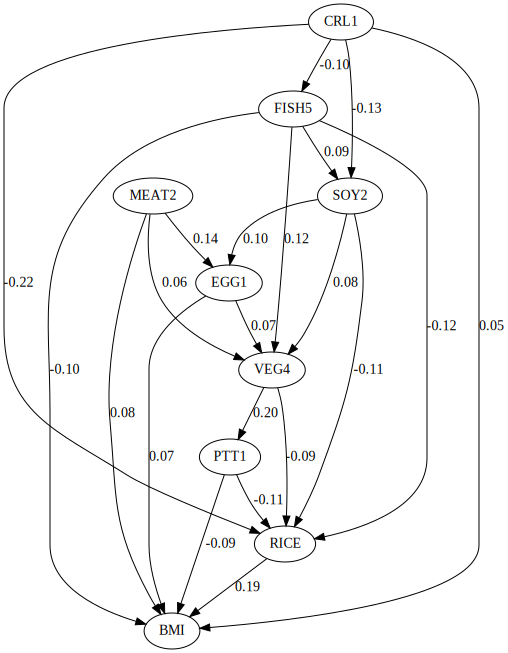

array([[0.00000000e+00, 5.67628630e-06, 7.45028101e-13, 1.36567235e-03,
        5.36692300e-11, 4.06384137e-10, 1.00470232e-17, 2.96098773e-09,
        0.00000000e+00],
       [5.67628630e-06, 0.00000000e+00, 5.39148290e-09, 1.61228728e-05,
        1.29181636e-05, 9.41203656e-14, 7.57765458e-02, 1.90641896e-05,
        1.86017284e-05],
       [7.45028101e-13, 5.39148290e-09, 0.00000000e+00, 8.33586640e-10,
        2.90649721e-06, 5.60070134e-07, 1.82897313e-19, 4.22359784e-16,
        3.90204024e-12],
       [1.36567235e-03, 1.61228728e-05, 8.33586640e-10, 0.00000000e+00,
        1.96286102e-06, 1.73882882e-07, 1.45570260e-01, 1.05142787e-11,
        1.27481536e-01],
       [5.36692300e-11, 1.29181636e-05, 2.90649721e-06, 1.96286102e-06,
        0.00000000e+00, 9.50173495e-19, 1.40610738e-01, 4.64397681e-05,
        1.75448661e-16],
       [4.06384137e-10, 9.41203656e-14, 5.60070134e-07, 1.73882882e-07,
        9.50173495e-19, 0.00000000e+00, 9.26048494e-03, 9.71203188e-12,
        2.6

因果順序
[6, 7, 2, 3, 1, 4, 5, 0, 8]


隣接行列


array([[ 0.        ,  0.        , -0.12543131,  0.        , -0.09193952,
        -0.11411224, -0.19741742, -0.12164866,  0.        ],
       [ 0.        ,  0.        ,  0.1419219 ,  0.1492053 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.12619777,  0.09236027,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.0786245 ,  0.071013  ,  0.07090894,  0.        ,
         0.        ,  0.        ,  0.11414021,  0.        ],
       [ 0.        ,  0.        ,  0.0842229 ,  0.        ,  0.16394536,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

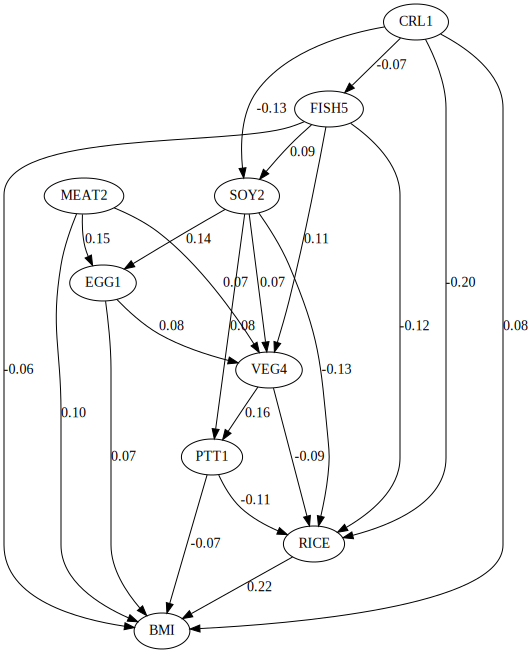

array([[0.00000000e+00, 1.92081172e-03, 4.03281007e-09, 6.10729251e-03,
        2.82152194e-06, 8.27593817e-05, 1.16917434e-10, 1.13528782e-07,
        0.00000000e+00],
       [1.92081172e-03, 0.00000000e+00, 3.88555229e-08, 5.60009295e-05,
        7.27426060e-03, 2.87995401e-07, 4.01009867e-01, 2.81358527e-05,
        3.89120359e-03],
       [4.03281007e-09, 3.88555229e-08, 0.00000000e+00, 8.94415167e-07,
        1.51935032e-05, 8.62371036e-05, 2.74952869e-10, 1.87358175e-12,
        5.54210686e-09],
       [6.10729251e-03, 5.60009295e-05, 8.94415167e-07, 0.00000000e+00,
        2.84939299e-03, 3.74610465e-03, 3.66914795e-01, 2.80091174e-12,
        5.84759835e-02],
       [2.82152194e-06, 7.27426060e-03, 1.51935032e-05, 2.84939299e-03,
        0.00000000e+00, 7.22275259e-10, 4.82353690e-01, 6.05754860e-05,
        1.05233331e-10],
       [8.27593817e-05, 2.87995401e-07, 8.62371036e-05, 3.74610465e-03,
        7.22275259e-10, 0.00000000e+00, 1.24515659e-01, 1.25750414e-06,
        6.3

因果順序
[6, 7, 2, 3, 1, 4, 5, 0, 8]


隣接行列


array([[ 0.        ,  0.        , -0.10809494, -0.08130461, -0.05465932,
        -0.09240253, -0.26156233, -0.24368588,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.17456145,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.11174898,  0.10937292,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.13235345,  0.        ,  0.        ,
         0.        ,  0.        ,  0.1346105 ,  0.        ],
       [ 0.        ,  0.06594838,  0.        ,  0.10108185,  0.23185526,
         0.        ,  0.        ,  0.08295234,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

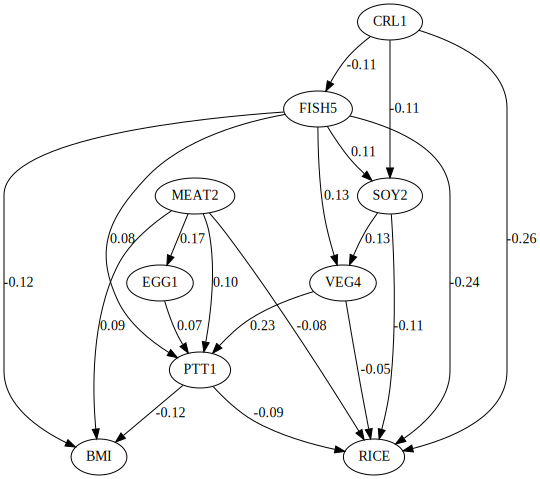

array([[0.00000000e+00, 1.22163967e-02, 6.79109856e-06, 6.93241053e-05,
        7.35861750e-03, 6.00957953e-03, 8.66103746e-13, 6.08294648e-16,
        1.20922199e-01],
       [1.22163967e-02, 0.00000000e+00, 2.27233916e-03, 5.46641988e-04,
        8.30202655e-04, 1.28916676e-05, 9.70128414e-02, 2.98406319e-03,
        1.14473240e-02],
       [6.79109856e-06, 2.27233916e-03, 0.00000000e+00, 9.81312856e-03,
        1.48889345e-05, 1.36063993e-02, 8.41136440e-09, 1.44914836e-08,
        1.05079660e-01],
       [6.93241053e-05, 5.46641988e-04, 9.81312856e-03, 0.00000000e+00,
        6.04457458e-03, 9.66934952e-03, 1.15861289e-01, 1.73286750e-04,
        3.37795145e-06],
       [7.35861750e-03, 8.30202655e-04, 1.48889345e-05, 6.04457458e-03,
        0.00000000e+00, 1.26516740e-10, 4.14333942e-01, 3.59252484e-03,
        4.50033025e-02],
       [6.00957953e-03, 1.28916676e-05, 1.36063993e-02, 9.66934952e-03,
        1.26516740e-10, 0.00000000e+00, 3.29777035e-02, 5.87335247e-06,
        1.2

因果順序
[6, 7, 2, 3, 1, 4, 5, 0, 8]


隣接行列


array([[ 0.        ,  0.        , -0.13070054, -0.08491185, -0.09241538,
        -0.08646619, -0.27091263, -0.27975079,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.21628856,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.09332845,  0.12704016,  0.        ,  0.        ,
         0.        ,  0.        ,  0.1398083 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.23024985,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

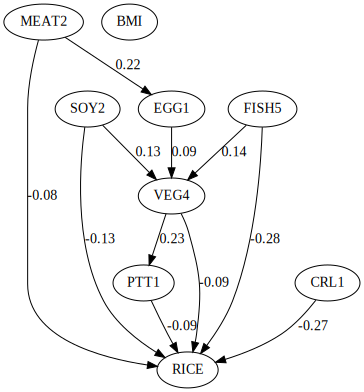

array([[0.00000000e+00, 2.95399642e-02, 2.83953370e-02, 3.25027681e-03,
        1.11388121e-03, 1.70618884e-01, 3.45497810e-09, 4.01074950e-08,
        3.71610944e-04],
       [2.95399642e-02, 0.00000000e+00, 4.94817540e-03, 1.19359181e-02,
        2.95664677e-01, 1.21850210e-03, 1.14225578e-01, 1.57866564e-01,
        3.95525893e-06],
       [2.83953370e-02, 4.94817540e-03, 0.00000000e+00, 9.45766159e-02,
        4.60391979e-05, 1.80002646e-03, 1.42962548e-03, 8.20126392e-06,
        3.23209484e-07],
       [3.25027681e-03, 1.19359181e-02, 9.45766159e-02, 0.00000000e+00,
        1.19092492e-01, 1.00217289e-01, 7.38544865e-02, 2.70705244e-06,
        3.44701896e-17],
       [1.11388121e-03, 2.95664677e-01, 4.60391979e-05, 1.19092492e-01,
        0.00000000e+00, 1.76946120e-04, 4.47554426e-01, 2.11558641e-02,
        9.57484863e-02],
       [1.70618884e-01, 1.21850210e-03, 1.80002646e-03, 1.00217289e-01,
        1.76946120e-04, 0.00000000e+00, 3.86380084e-02, 1.30823042e-03,
        6.6

因果順序
[6, 7, 2, 3, 1, 4, 5, 0, 8]


隣接行列


array([[ 0.        ,  0.        , -0.1269801 , -0.0761737 , -0.06636431,
        -0.13510219, -0.27929133, -0.16037617,  0.        ],
       [ 0.        ,  0.        ,  0.12152195,  0.11981822,  0.        ,
         0.        ,  0.        , -0.09641689,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.13014884,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.09807398,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.14119341,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.17230476,
         0.        , -0.09703235,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

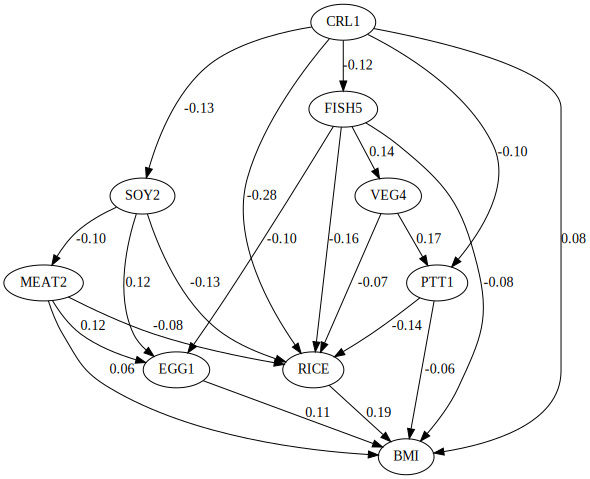

array([[0.00000000e+000, 2.08787862e-003, 1.81806960e-010,
        5.63000050e-002, 4.56038680e-006, 6.18070687e-008,
        3.79784064e-013, 6.78592533e-011, 2.42026498e-266],
       [2.08787862e-003, 0.00000000e+000, 1.50854909e-007,
        1.81900969e-002, 1.93751005e-002, 5.31772143e-009,
        2.29127871e-001, 2.13901411e-004, 1.02303521e-003],
       [1.81806960e-010, 1.50854909e-007, 0.00000000e+000,
        4.17927469e-004, 4.13664205e-002, 7.76259732e-005,
        1.07829507e-009, 1.09307999e-009, 3.64353954e-009],
       [5.63000050e-002, 1.81900969e-002, 4.17927469e-004,
        0.00000000e+000, 1.32724832e-005, 6.29215042e-004,
        2.59230580e-001, 9.29295108e-005, 2.46519115e-001],
       [4.56038680e-006, 1.93751005e-002, 4.13664205e-002,
        1.32724832e-005, 0.00000000e+000, 5.72382166e-008,
        7.46745902e-003, 1.51866149e-002, 1.43598083e-009],
       [6.18070687e-008, 5.31772143e-009, 7.76259732e-005,
        6.29215042e-004, 5.72382166e-008, 0.0000000

因果順序
[6, 7, 2, 3, 1, 4, 5, 0, 8]


隣接行列


array([[ 0.        ,  0.        , -0.17709864, -0.07977804, -0.0677047 ,
        -0.14659062, -0.29790738, -0.15862376,  0.        ],
       [ 0.        ,  0.        ,  0.21162332,  0.1071058 ,  0.        ,
         0.        ,  0.        , -0.08321324,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.14344926,  0.08983005,  0.        ],
       [ 0.        ,  0.        , -0.14933835,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.10551897,  0.09690589,  0.        ,
         0.        ,  0.        ,  0.11952799,  0.        ],
       [ 0.        ,  0.        ,  0.07711076,  0.        ,  0.15387422,
         0.        , -0.09822199,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

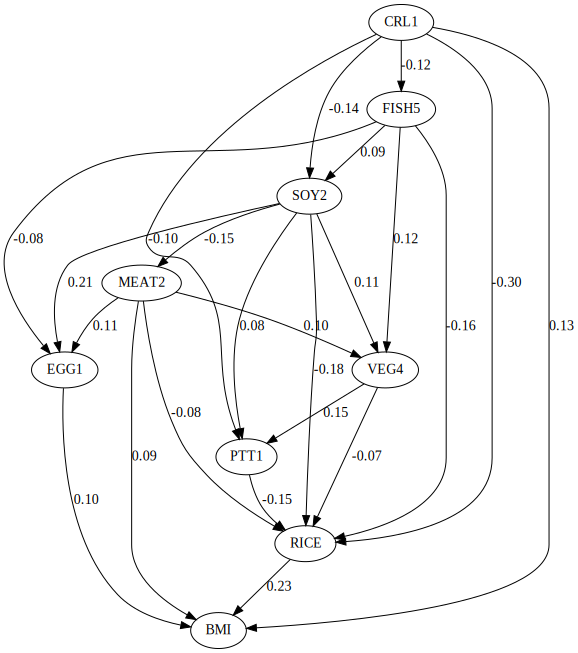

array([[0.00000000e+000, 1.80013243e-001, 6.76551654e-009,
        1.32407948e-001, 2.09286502e-003, 1.71347539e-005,
        1.62001896e-009, 1.05960012e-008, 1.55988376e-215],
       [1.80013243e-001, 0.00000000e+000, 5.18066322e-007,
        9.51540864e-002, 1.28913023e-001, 2.56839265e-005,
        4.88884237e-001, 9.78193314e-003, 2.38375792e-001],
       [6.76551654e-009, 5.18066322e-007, 0.00000000e+000,
        2.48999645e-003, 5.68955386e-002, 1.09361911e-003,
        1.78486214e-006, 5.76564131e-007, 1.82094056e-010],
       [1.32407948e-001, 9.51540864e-002, 2.48999645e-003,
        0.00000000e+000, 8.46539486e-002, 9.01597028e-002,
        6.85255074e-001, 2.51935568e-003, 1.80662550e-001],
       [2.09286502e-003, 1.28913023e-001, 5.68955386e-002,
        8.46539486e-002, 0.00000000e+000, 1.75300849e-005,
        1.23839018e-001, 1.93377503e-002, 1.10152239e-005],
       [1.71347539e-005, 2.56839265e-005, 1.09361911e-003,
        9.01597028e-002, 1.75300849e-005, 0.0000000

In [27]:
# # マルチリンガム
model = model_MultiDirectLiNGAM(food_data_list)

In [28]:
# ブートストラップ法：引数（データフレームリスト, サンプル回数）
pretty_causal_effects = model_MultiBootstrap(food_data_list, 1000)
display(pretty_causal_effects)



=============================================food_bootstrap_0=============================================
因果方法top10
RICE <--- CRL1 (b<0) (100.0%)
RICE <--- FISH5 (b<0) (99.9%)
BMI <--- FISH5 (b<0) (99.8%)
RICE <--- SOY2 (b<0) (99.7%)
VEG4 <--- FISH5 (b>0) (98.6%)
RICE <--- PTT1 (b<0) (97.2%)
RICE <--- VEG4 (b<0) (95.8%)
SOY2 <--- FISH5 (b>0) (92.5%)
EGG1 <--- SOY2 (b>0) (91.3%)
BMI <--- RICE (b>0) (89.2%)

カウント確率


,RICE,EGG1,SOY2,MEAT2,VEG4,PTT1,CRL1,FISH5,BMI
RICE,0.000,0.053,0.997,0.172,0.958,0.972,1.000,0.999,0.108
EGG1,0.006,0.000,0.913,0.762,0.480,0.116,0.059,0.381,0.000
SOY2,0.003,0.004,0.000,0.218,0.222,0.037,0.670,0.925,0.000
MEAT2,0.027,0.238,0.316,0.000,0.159,0.078,0.108,0.041,0.052
VEG4,0.018,0.323,0.638,0.454,0.000,0.451,0.142,0.986,0.024
PTT1,0.021,0.260,0.488,0.442,0.549,0.000,0.348,0.684,0.130
CRL1,0.000,0.000,0.330,0.011,0.004,0.002,0.000,0.360,0.000
FISH5,0.000,0.001,0.000,0.006,0.001,0.003,0.579,0.000,0.000
BMI,0.892,0.825,0.133,0.838,0.081,0.826,0.479,0.998,0.000



DAGのカウント結果
DAG[0]: 0.2%
	RICE <--- SOY2 (b<0)
	RICE <--- VEG4 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	EGG1 <--- SOY2 (b>0)
	EGG1 <--- MEAT2 (b>0)
	SOY2 <--- CRL1 (b<0)
	SOY2 <--- FISH5 (b>0)
	MEAT2 <--- SOY2 (b<0)
	VEG4 <--- EGG1 (b>0)
	VEG4 <--- SOY2 (b>0)
	VEG4 <--- MEAT2 (b>0)
	VEG4 <--- FISH5 (b>0)
	PTT1 <--- SOY2 (b>0)
	PTT1 <--- VEG4 (b>0)
	FISH5 <--- CRL1 (b<0)
	BMI <--- RICE (b>0)
	BMI <--- EGG1 (b>0)
	BMI <--- MEAT2 (b>0)
	BMI <--- PTT1 (b<0)
	BMI <--- FISH5 (b<0)
DAG[1]: 0.1%
	RICE <--- EGG1 (b<0)
	RICE <--- SOY2 (b<0)
	RICE <--- MEAT2 (b<0)
	RICE <--- VEG4 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	EGG1 <--- SOY2 (b>0)
	SOY2 <--- FISH5 (b>0)
	MEAT2 <--- EGG1 (b>0)
	MEAT2 <--- SOY2 (b<0)
	VEG4 <--- EGG1 (b>0)
	VEG4 <--- SOY2 (b>0)
	VEG4 <--- MEAT2 (b>0)
	VEG4 <--- FISH5 (b>0)
	PTT1 <--- SOY2 (b>0)
	PTT1 <--- MEAT2 (b>0)
	PTT1 <--- VEG4 (b>0)
	PTT1 <--- FISH5 (b>0)
	CRL1 <--- SOY2 (b<0)
	BMI <--- RICE (b>0)
	BMI

,from,to,effect,probability
0,FISH5,BMI,-0.143396,1.000
1,CRL1,RICE,-0.190866,1.000
2,FISH5,RICE,-0.144824,1.000
3,FISH5,VEG4,0.121441,0.995
4,SOY2,RICE,-0.115540,0.991
...,...,...,...,...
59,PTT1,CRL1,-0.071397,0.003
60,PTT1,FISH5,0.081211,0.003
61,RICE,SOY2,-0.116921,0.003
62,VEG4,FISH5,0.149693,0.001




=============================================food_bootstrap_1=============================================
因果方法top10
RICE <--- CRL1 (b<0) (100.0%)
RICE <--- SOY2 (b<0) (99.1%)
RICE <--- FISH5 (b<0) (98.7%)
EGG1 <--- SOY2 (b>0) (98.2%)
RICE <--- PTT1 (b<0) (95.9%)
VEG4 <--- FISH5 (b>0) (93.3%)
RICE <--- VEG4 (b<0) (91.2%)
BMI <--- RICE (b>0) (89.2%)
BMI <--- MEAT2 (b>0) (87.4%)
SOY2 <--- FISH5 (b>0) (84.5%)

カウント確率


,RICE,EGG1,SOY2,MEAT2,VEG4,PTT1,CRL1,FISH5,BMI
RICE,0.000,0.204,0.991,0.250,0.912,0.959,1.000,0.987,0.108
EGG1,0.025,0.000,0.982,0.762,0.430,0.082,0.082,0.492,0.000
SOY2,0.003,0.004,0.000,0.233,0.180,0.056,0.661,0.845,0.000
MEAT2,0.038,0.238,0.413,0.000,0.171,0.035,0.143,0.019,0.056
VEG4,0.018,0.300,0.448,0.430,0.000,0.451,0.037,0.933,0.007
PTT1,0.020,0.191,0.650,0.223,0.549,0.000,0.267,0.362,0.112
CRL1,0.000,0.000,0.328,0.008,0.000,0.000,0.000,0.167,0.000
FISH5,0.000,0.000,0.000,0.002,0.001,0.001,0.302,0.000,0.000
BMI,0.892,0.634,0.236,0.874,0.134,0.563,0.752,0.602,0.000



DAGのカウント結果
DAG[0]: 0.1%
	RICE <--- SOY2 (b<0)
	RICE <--- MEAT2 (b<0)
	RICE <--- VEG4 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	EGG1 <--- MEAT2 (b>0)
	SOY2 <--- CRL1 (b<0)
	SOY2 <--- FISH5 (b>0)
	VEG4 <--- SOY2 (b>0)
	VEG4 <--- MEAT2 (b>0)
	VEG4 <--- PTT1 (b>0)
	VEG4 <--- CRL1 (b<0)
	VEG4 <--- FISH5 (b>0)
	PTT1 <--- SOY2 (b>0)
	PTT1 <--- MEAT2 (b>0)
	PTT1 <--- CRL1 (b<0)
	BMI <--- RICE (b>0)
	BMI <--- FISH5 (b<0)
DAG[1]: 0.1%
	RICE <--- SOY2 (b<0)
	RICE <--- VEG4 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	EGG1 <--- RICE (b>0)
	EGG1 <--- SOY2 (b>0)
	EGG1 <--- MEAT2 (b>0)
	EGG1 <--- VEG4 (b>0)
	EGG1 <--- CRL1 (b>0)
	SOY2 <--- CRL1 (b<0)
	VEG4 <--- PTT1 (b>0)
	VEG4 <--- FISH5 (b>0)
	PTT1 <--- SOY2 (b>0)
	FISH5 <--- CRL1 (b<0)
	BMI <--- RICE (b>0)
	BMI <--- EGG1 (b>0)
	BMI <--- MEAT2 (b>0)
	BMI <--- PTT1 (b<0)
	BMI <--- CRL1 (b>0)
	BMI <--- FISH5 (b<0)
DAG[2]: 0.1%
	RICE <--- SOY2 (b<0)
	RICE <--- VEG4 (b<0)
	RICE <--- PTT1 (b<

,from,to,effect,probability
0,CRL1,RICE,-0.171347,0.999
1,FISH5,RICE,-0.144479,0.997
2,SOY2,RICE,-0.131266,0.991
3,SOY2,EGG1,0.138418,0.972
4,PTT1,RICE,-0.120082,0.958
...,...,...,...,...
57,RICE,SOY2,-0.124622,0.003
58,MEAT2,FISH5,-0.074208,0.002
59,PTT1,CRL1,-0.077805,0.002
60,PTT1,FISH5,0.072473,0.001




=============================================food_bootstrap_2=============================================
因果方法top10
RICE <--- CRL1 (b<0) (100.0%)
RICE <--- FISH5 (b<0) (100.0%)
RICE <--- SOY2 (b<0) (86.7%)
VEG4 <--- FISH5 (b>0) (86.3%)
BMI <--- FISH5 (b<0) (77.4%)
RICE <--- PTT1 (b<0) (77.2%)
SOY2 <--- FISH5 (b>0) (75.0%)
EGG1 <--- MEAT2 (b>0) (74.6%)
VEG4 <--- SOY2 (b>0) (69.7%)
PTT1 <--- MEAT2 (b>0) (69.1%)

カウント確率


,RICE,EGG1,SOY2,MEAT2,VEG4,PTT1,CRL1,FISH5,BMI
RICE,0.000,0.082,0.867,0.542,0.399,0.772,1.000,1.000,0.038
EGG1,0.014,0.000,0.176,0.746,0.097,0.180,0.064,0.117,0.000
SOY2,0.003,0.000,0.000,0.024,0.227,0.008,0.534,0.750,0.000
MEAT2,0.058,0.233,0.025,0.000,0.054,0.110,0.133,0.029,0.032
VEG4,0.005,0.069,0.697,0.166,0.000,0.451,0.033,0.863,0.049
PTT1,0.016,0.258,0.117,0.691,0.549,0.000,0.197,0.677,0.095
CRL1,0.000,0.000,0.250,0.022,0.000,0.000,0.000,0.273,0.000
FISH5,0.000,0.000,0.000,0.003,0.001,0.002,0.474,0.000,0.000
BMI,0.322,0.030,0.146,0.546,0.354,0.621,0.024,0.774,0.000



DAGのカウント結果
DAG[0]: 0.1%
	RICE <--- EGG1 (b<0)
	RICE <--- SOY2 (b<0)
	RICE <--- MEAT2 (b<0)
	RICE <--- VEG4 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	SOY2 <--- CRL1 (b<0)
	SOY2 <--- FISH5 (b>0)
	MEAT2 <--- EGG1 (b>0)
	VEG4 <--- SOY2 (b>0)
	VEG4 <--- FISH5 (b>0)
	PTT1 <--- EGG1 (b>0)
	PTT1 <--- MEAT2 (b>0)
	PTT1 <--- VEG4 (b>0)
	BMI <--- MEAT2 (b>0)
	BMI <--- FISH5 (b<0)
DAG[1]: 0.1%
	RICE <--- SOY2 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	SOY2 <--- FISH5 (b>0)
	VEG4 <--- SOY2 (b>0)
	VEG4 <--- FISH5 (b>0)
	PTT1 <--- EGG1 (b>0)
	PTT1 <--- MEAT2 (b>0)
	PTT1 <--- VEG4 (b>0)
	PTT1 <--- FISH5 (b>0)
	CRL1 <--- FISH5 (b<0)
	BMI <--- PTT1 (b<0)
DAG[2]: 0.1%
	RICE <--- SOY2 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	SOY2 <--- FISH5 (b>0)
	VEG4 <--- SOY2 (b>0)
	VEG4 <--- PTT1 (b>0)
	PTT1 <--- FISH5 (b>0)
	FISH5 <--- CRL1 (b<0)
	BMI <--- MEAT2 (b>0)
	BMI <--- PTT1 (b<0)
	BMI <--- FISH5 (b<0)



,from,to,effect,probability
0,CRL1,RICE,-0.231760,1.000
1,FISH5,RICE,-0.264985,1.000
2,FISH5,VEG4,0.152892,0.947
3,FISH5,BMI,-0.140821,0.879
4,PTT1,RICE,-0.127094,0.835
5,FISH5,PTT1,0.133754,0.826
6,FISH5,SOY2,0.125988,0.792
7,SOY2,RICE,-0.120886,0.769
8,MEAT2,EGG1,0.173461,0.752
9,MEAT2,PTT1,0.136420,0.725




=============================================food_bootstrap_3=============================================
因果方法top10
RICE <--- CRL1 (b<0) (100.0%)
RICE <--- FISH5 (b<0) (100.0%)
RICE <--- SOY2 (b<0) (89.8%)
VEG4 <--- FISH5 (b>0) (76.5%)
EGG1 <--- MEAT2 (b>0) (75.2%)
RICE <--- VEG4 (b<0) (66.4%)
RICE <--- PTT1 (b<0) (62.0%)
PTT1 <--- VEG4 (b>0) (54.3%)
VEG4 <--- SOY2 (b>0) (54.1%)
BMI <--- MEAT2 (b>0) (53.1%)

カウント確率


,RICE,EGG1,SOY2,MEAT2,VEG4,PTT1,CRL1,FISH5,BMI
RICE,0.000,0.042,0.898,0.496,0.664,0.620,1.000,1.000,0.057
EGG1,0.004,0.000,0.050,0.752,0.200,0.187,0.042,0.022,0.000
SOY2,0.003,0.000,0.000,0.017,0.200,0.010,0.251,0.240,0.000
MEAT2,0.065,0.235,0.037,0.000,0.023,0.046,0.140,0.030,0.040
VEG4,0.013,0.164,0.541,0.061,0.000,0.450,0.056,0.765,0.005
PTT1,0.014,0.312,0.147,0.338,0.543,0.000,0.027,0.452,0.069
CRL1,0.000,0.000,0.151,0.024,0.000,0.002,0.000,0.036,0.000
FISH5,0.000,0.000,0.000,0.000,0.001,0.002,0.074,0.000,0.000
BMI,0.362,0.030,0.048,0.531,0.022,0.333,0.054,0.373,0.000



DAGのカウント結果
DAG[0]: 0.2%
	RICE <--- SOY2 (b<0)
	RICE <--- MEAT2 (b<0)
	RICE <--- VEG4 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	EGG1 <--- MEAT2 (b>0)
	VEG4 <--- SOY2 (b>0)
	VEG4 <--- PTT1 (b>0)
	VEG4 <--- FISH5 (b>0)
	PTT1 <--- FISH5 (b>0)
	BMI <--- MEAT2 (b>0)
DAG[1]: 0.2%
	RICE <--- SOY2 (b<0)
	RICE <--- VEG4 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	EGG1 <--- MEAT2 (b>0)
	VEG4 <--- SOY2 (b>0)
	VEG4 <--- PTT1 (b>0)
	VEG4 <--- FISH5 (b>0)
	BMI <--- MEAT2 (b>0)
DAG[2]: 0.1%
	RICE <--- EGG1 (b<0)
	RICE <--- SOY2 (b<0)
	RICE <--- MEAT2 (b<0)
	RICE <--- VEG4 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	EGG1 <--- MEAT2 (b>0)
	VEG4 <--- FISH5 (b>0)
	PTT1 <--- MEAT2 (b>0)
	PTT1 <--- VEG4 (b>0)
	CRL1 <--- SOY2 (b<0)
	BMI <--- MEAT2 (b>0)



,from,to,effect,probability
0,FISH5,RICE,-0.301766,1.000
1,CRL1,RICE,-0.239407,0.999
2,SOY2,RICE,-0.151531,0.834
3,FISH5,VEG4,0.159330,0.824
4,VEG4,RICE,-0.136685,0.758
5,MEAT2,EGG1,0.215357,0.757
6,PTT1,RICE,-0.134894,0.677
7,SOY2,VEG4,0.148644,0.563
8,FISH5,PTT1,0.144543,0.558
9,VEG4,PTT1,0.221833,0.546




=============================================food_bootstrap_4=============================================
因果方法top10
RICE <--- CRL1 (b<0) (100.0%)
RICE <--- FISH5 (b<0) (100.0%)
RICE <--- SOY2 (b<0) (97.9%)
VEG4 <--- FISH5 (b>0) (97.7%)
RICE <--- PTT1 (b<0) (97.5%)
EGG1 <--- SOY2 (b>0) (90.4%)
BMI <--- RICE (b>0) (89.2%)
BMI <--- EGG1 (b>0) (89.1%)
EGG1 <--- FISH5 (b<0) (85.1%)
BMI <--- FISH5 (b<0) (84.2%)

カウント確率


,RICE,EGG1,SOY2,MEAT2,VEG4,PTT1,CRL1,FISH5,BMI
RICE,0.000,0.185,0.979,0.653,0.691,0.975,1.000,1.000,0.108
EGG1,0.042,0.000,0.904,0.732,0.355,0.115,0.065,0.851,0.000
SOY2,0.003,0.004,0.000,0.299,0.159,0.033,0.644,0.348,0.000
MEAT2,0.088,0.214,0.561,0.000,0.116,0.022,0.192,0.060,0.025
VEG4,0.008,0.207,0.400,0.272,0.000,0.451,0.135,0.977,0.007
PTT1,0.023,0.244,0.333,0.147,0.548,0.000,0.764,0.492,0.112
CRL1,0.000,0.000,0.320,0.012,0.003,0.004,0.000,0.384,0.000
FISH5,0.000,0.000,0.000,0.004,0.001,0.003,0.552,0.000,0.000
BMI,0.892,0.891,0.242,0.449,0.153,0.515,0.688,0.842,0.000



DAGのカウント結果
DAG[0]: 0.1%
	RICE <--- EGG1 (b<0)
	RICE <--- SOY2 (b<0)
	RICE <--- MEAT2 (b<0)
	RICE <--- VEG4 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	SOY2 <--- MEAT2 (b<0)
	VEG4 <--- FISH5 (b>0)
	PTT1 <--- EGG1 (b>0)
	PTT1 <--- MEAT2 (b>0)
	PTT1 <--- VEG4 (b>0)
	PTT1 <--- CRL1 (b<0)
	PTT1 <--- FISH5 (b>0)
	CRL1 <--- SOY2 (b<0)
	CRL1 <--- FISH5 (b<0)
	BMI <--- RICE (b>0)
	BMI <--- FISH5 (b<0)
DAG[1]: 0.1%
	RICE <--- SOY2 (b<0)
	RICE <--- MEAT2 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	EGG1 <--- SOY2 (b>0)
	EGG1 <--- MEAT2 (b>0)
	EGG1 <--- VEG4 (b>0)
	EGG1 <--- PTT1 (b>0)
	EGG1 <--- FISH5 (b<0)
	SOY2 <--- MEAT2 (b<0)
	SOY2 <--- PTT1 (b>0)
	SOY2 <--- CRL1 (b<0)
	VEG4 <--- PTT1 (b>0)
	VEG4 <--- FISH5 (b>0)
	FISH5 <--- PTT1 (b>0)
	FISH5 <--- CRL1 (b<0)
	BMI <--- RICE (b>0)
	BMI <--- EGG1 (b>0)
	BMI <--- PTT1 (b<0)
DAG[2]: 0.1%
	RICE <--- SOY2 (b<0)
	RICE <--- MEAT2 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FI

,from,to,effect,probability
0,CRL1,RICE,-0.236342,1.000
1,FISH5,RICE,-0.174351,1.000
2,FISH5,VEG4,0.140703,0.988
3,FISH5,BMI,-0.136978,0.987
4,PTT1,RICE,-0.145172,0.974
...,...,...,...,...
58,RICE,SOY2,-0.172914,0.003
59,VEG4,CRL1,-0.066602,0.003
60,EGG1,SOY2,0.080405,0.003
61,PTT1,FISH5,0.099598,0.003




=============================================food_bootstrap_5=============================================
因果方法top10
RICE <--- CRL1 (b<0) (100.0%)
RICE <--- SOY2 (b<0) (99.6%)
RICE <--- FISH5 (b<0) (99.6%)
EGG1 <--- SOY2 (b>0) (99.1%)
RICE <--- PTT1 (b<0) (96.8%)
BMI <--- RICE (b>0) (89.1%)
VEG4 <--- FISH5 (b>0) (88.6%)
BMI <--- CRL1 (b>0) (79.4%)
PTT1 <--- CRL1 (b<0) (72.8%)
BMI <--- EGG1 (b>0) (70.5%)

カウント確率


,RICE,EGG1,SOY2,MEAT2,VEG4,PTT1,CRL1,FISH5,BMI
RICE,0.000,0.048,0.996,0.630,0.601,0.968,1.000,0.996,0.108
EGG1,0.008,0.000,0.991,0.592,0.163,0.060,0.047,0.564,0.000
SOY2,0.003,0.004,0.000,0.338,0.193,0.051,0.661,0.690,0.000
MEAT2,0.082,0.166,0.641,0.000,0.175,0.017,0.079,0.023,0.045
VEG4,0.015,0.116,0.453,0.397,0.000,0.444,0.067,0.886,0.014
PTT1,0.024,0.148,0.558,0.158,0.538,0.000,0.728,0.309,0.070
CRL1,0.000,0.000,0.319,0.009,0.003,0.004,0.000,0.364,0.000
FISH5,0.000,0.001,0.000,0.001,0.001,0.001,0.519,0.000,0.000
BMI,0.891,0.705,0.277,0.648,0.240,0.263,0.794,0.360,0.000



DAGのカウント結果
DAG[0]: 0.1%
	RICE <--- EGG1 (b<0)
	RICE <--- SOY2 (b<0)
	RICE <--- MEAT2 (b<0)
	RICE <--- VEG4 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	EGG1 <--- SOY2 (b>0)
	EGG1 <--- FISH5 (b<0)
	SOY2 <--- MEAT2 (b<0)
	VEG4 <--- SOY2 (b>0)
	VEG4 <--- MEAT2 (b>0)
	VEG4 <--- PTT1 (b>0)
	VEG4 <--- FISH5 (b>0)
	PTT1 <--- SOY2 (b>0)
	PTT1 <--- CRL1 (b<0)
	CRL1 <--- SOY2 (b<0)
	CRL1 <--- FISH5 (b<0)
	BMI <--- RICE (b>0)
	BMI <--- EGG1 (b>0)
	BMI <--- SOY2 (b>0)
	BMI <--- MEAT2 (b>0)
	BMI <--- VEG4 (b>0)
	BMI <--- PTT1 (b<0)
	BMI <--- CRL1 (b>0)
DAG[1]: 0.1%
	RICE <--- SOY2 (b<0)
	RICE <--- VEG4 (b<0)
	RICE <--- PTT1 (b<0)
	RICE <--- CRL1 (b<0)
	RICE <--- FISH5 (b<0)
	EGG1 <--- SOY2 (b>0)
	SOY2 <--- CRL1 (b<0)
	MEAT2 <--- SOY2 (b<0)
	VEG4 <--- PTT1 (b>0)
	VEG4 <--- FISH5 (b>0)
	PTT1 <--- SOY2 (b>0)
	PTT1 <--- CRL1 (b<0)
	FISH5 <--- CRL1 (b<0)
	BMI <--- RICE (b>0)
	BMI <--- MEAT2 (b>0)
	BMI <--- CRL1 (b>0)
DAG[2]: 0.1%
	RICE <--- SOY2 (b<0)
	RICE <--- VEG4 (b<0)


,from,to,effect,probability
0,CRL1,RICE,-0.247173,1.000
1,SOY2,EGG1,0.196752,0.992
2,FISH5,RICE,-0.177635,0.988
3,SOY2,RICE,-0.173602,0.987
4,PTT1,RICE,-0.158140,0.963
...,...,...,...,...
59,MEAT2,CRL1,-0.096723,0.003
60,PTT1,FISH5,0.148526,0.001
61,MEAT2,FISH5,-0.095784,0.001
62,EGG1,FISH5,-0.104065,0.001


None

## DAGのカウントはすべて1％未満。
##RICE,MEAT,PTT,EGGあたり、炭水化物、タンパク質などはBMIに対する因果パスは比較的得られているか。一方で、FISH5（脂身が多い魚）は、脂身が多くてもBMI増加に対する影響は少ない様子。CRL1→RICE、FISH→RICEの負の因果はそれぞれ、主食がパンなら飯は食べない、刺身でたべるので飯は食べない、のような因果であると言えそう。<br>
##サンプリング回数1000にしてもDAG0.3%なので実装が根本から良くない可能性（変数減らす、選び直す）